# Sentinel-3
Let's use EOReader to open and read some Sentinel-3 bands and see the specificities of OLCI and SLSTR sensors.

<div class="alert alert-info">
Note that Sentinel-3 processes have stopped to use SNAP since the 0.8.0 version.
Some minor discrepancies might occur both in the geocoding (especially OLCI) and the reflectance values (SLSTR).
</div>

In [1]:
# Imports
import os
import warnings
import rasterio

# EOReader
from eoreader.reader import Reader
from eoreader.bands import YELLOW, Oa21, RED, SWIR_2, F1

# Disable georef warnings here as the SAR products are not georeferenced
warnings.filterwarnings("ignore", category=rasterio.errors.NotGeoreferencedWarning)

# Declare the reader (only once)
reader = Reader()

In [2]:
# Create logger
import logging

logger = logging.getLogger("eoreader")
logger.setLevel(logging.DEBUG)

# create console handler and set level to debug
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

# create formatter
formatter = logging.Formatter('%(message)s')

# add formatter to ch
ch.setFormatter(formatter)

# add ch to logger
logger.addHandler(ch)

## Sentinel-3 OLCI

In [3]:
# First of all, let's focus on Sentinel-3 OLCI data
olci_path = os.path.join(
    "/home", "data", "DATA", "PRODS", "S3",
    "S3A_OL_1_EFR____20191215T105023_20191215T105323_20191216T153115_0179_052_322_2160_LN1_O_NT_002.zip"
)
olci_prod = reader.open(olci_path, remove_tmp=True)
olci_prod

In [ ]:
# Get the bands information
olci_prod.bands

In [4]:
# Load the Yellow band and the far NIR one
# Please note that mapped band need to be called by their mapped name and the specific one with their true name
olci_bands = olci_prod.load([YELLOW, Oa21])

Loading bands ['YELLOW', 'Oa21']
Converting YELLOW to reflectance
Geocoding YELLOW
Converting Oa21 to reflectance
Geocoding Oa21
Read YELLOW
Manage invalid pixels for band YELLOW
Geocoding qualityFlags
Read Oa21
Manage invalid pixels for band Oa21


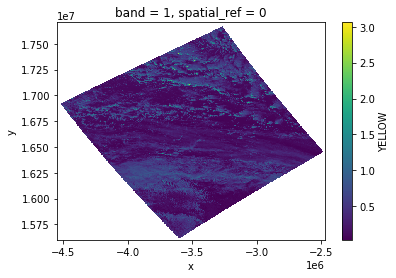

In [5]:
# Plot a subsampled version
olci_bands[YELLOW][:, ::10, ::10].plot()

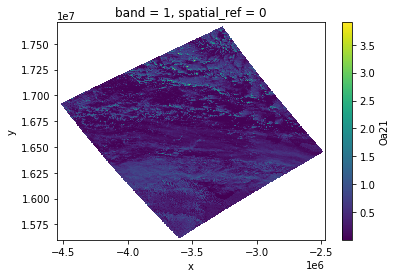

In [6]:
olci_bands[Oa21][:, ::10, ::10].plot()

## Sentinel-3 SLSTR

In [7]:
# Other SLSTR imports
from eoreader.keywords import SLSTR_VIEW, SLSTR_STRIPE, SLSTR_RAD_ADJUST
from eoreader.products import SlstrRadAdjustTuple, SlstrRadAdjust, SlstrView, SlstrStripe

# Then, let's focus on Sentinel-3 SLSTR data (extracted here, but a zip would work)
slstr_path = os.path.join(
    "/home", "data", "DATA", "PRODS", "S3",
    "S3B_SL_1_RBT____20191115T233722_20191115T234022_20191117T031722_0179_032_144_3420_LN2_O_NT_003.SEN3"
)
slstr_prod = reader.open(slstr_path, remove_tmp=True)
slstr_prod

In [ ]:
# Get the bands information
slstr_prod.bands

In [8]:
# Same remark for mapped and specific band than above
# Not that native radiance band are converted into reflectance, whereas brilliance temperature bands are not

# Load bands with nadir view and stripe B
# (for bands that have a stripe B, the other will load their unique stripe, namely A or I)
# RED: only stripe A
# SWIR_2: has strip 1, B and TDI (c)
# F1: has only stripe I
slstr_bn_bands = slstr_prod.load([RED, SWIR_2, F1], slstr_view="n", slstr_stripe="b")
slstr_bn_bands_2 = slstr_prod.load([RED, SWIR_2, F1], **{SLSTR_VIEW: SlstrView.NADIR, SLSTR_STRIPE: SlstrStripe.B})

Loading bands ['SWIR_2', 'F1', 'RED']
Converting SWIR_2 to reflectance
Geocoding SWIR_2
Geocoding F1
Converting RED to reflectance
Geocoding RED
Read SWIR_2
Manage invalid pixels for band SWIR_2
Geocoding S6_exception_bn
Read F1
Manage invalid pixels for band F1
Geocoding F1_exception_in
Read RED
Manage invalid pixels for band RED
Geocoding S2_exception_an
Loading bands ['SWIR_2', 'F1', 'RED']
Read SWIR_2
Read F1
Read RED


In [10]:
# You can use the keywords by importing them or copy their value.
# Their values can be passed as strings or as an Enum
# However, it seems safer to import the keywords and use the enum
# The result should be the same

# Please bear in mind that oblique and nadir views are not stackable !
# However, you can stack different stripes
# (but you cannot load them at once and you should collocate them to be sure, their reprojection grid may vary as their GCP vary)

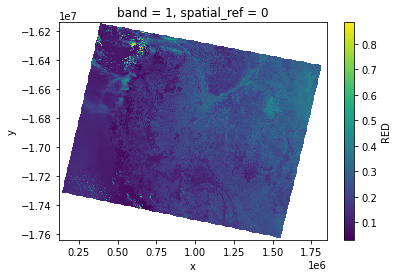

In [11]:
# Plot a subsampled version
slstr_bn_bands[RED][:, ::10, ::10].plot()

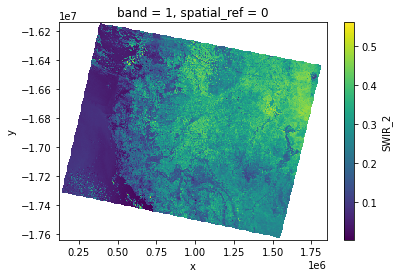

In [12]:
slstr_bn_bands[SWIR_2][:, ::10, ::10].plot()

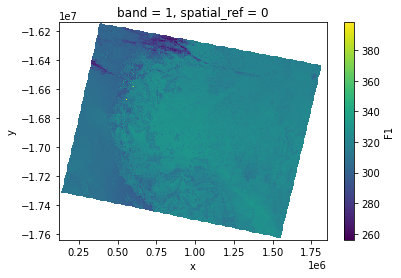

In [13]:
slstr_bn_bands[F1][:, ::10, ::10].plot()

In [14]:
# Sentinel-3 SLSTR radiance is not nominal, so EUMETSAT advises the user to make some radiance adjustments
# As stated here: https://www-cdn.eumetsat.int/files/2021-05/S3.PN-SLSTR-L1.08%20-%20i1r0%20-%20SLSTR%20L1%20PB%202.75-A%20and%201.53-B.pdf
# These coefficients have been added since the 06 version and several sets exist:

# The last one (S3.PN-SLSTR-L1.08, since 18/05/2021) which is also the default one
SlstrRadAdjust.S3_PN_SLSTR_L1_08

<SlstrRadAdjust.S3_PN_SLSTR_L1_08: SlstrRadAdjustTuple(S1_n=0.97, S2_n=0.98, S3_n=0.98, S4_n=1.0, S5_n=1.11, S6_n=1.13, S1_o=0.94, S2_o=0.95, S3_o=0.95, S4_o=1.0, S5_o=1.04, S6_o=1.07)>

In [15]:
# The two older sets given by EUMETSAT are the same
assert SlstrRadAdjust.S3_PN_SLSTR_L1_07 == SlstrRadAdjust.S3_PN_SLSTR_L1_06
SlstrRadAdjust.S3_PN_SLSTR_L1_07


<SlstrRadAdjust.S3_PN_SLSTR_L1_06: SlstrRadAdjustTuple(S1_n=1.0, S2_n=1.0, S3_n=1.0, S4_n=1.0, S5_n=1.12, S6_n=1.15, S1_o=1.0, S2_o=1.0, S3_o=1.0, S4_o=1.0, S5_o=1.2, S6_o=1.26)>

In [16]:
# Moreover, SNAP uses a different set with unknown origin (optional, in S3MPC Calibration)
SlstrRadAdjust.SNAP

<SlstrRadAdjust.SNAP: SlstrRadAdjustTuple(S1_n=1.0, S2_n=1.0, S3_n=1.0, S4_n=1.0, S5_n=1.12, S6_n=1.13, S1_o=1.0, S2_o=1.0, S3_o=1.0, S4_o=1.0, S5_o=1.15, S6_o=1.14)>

In [17]:
# A default set also exists, with every coefficient set to 1.0
SlstrRadAdjust.NONE

<SlstrRadAdjust.NONE: SlstrRadAdjustTuple(S1_n=1.0, S2_n=1.0, S3_n=1.0, S4_n=1.0, S5_n=1.0, S6_n=1.0, S1_o=1.0, S2_o=1.0, S3_o=1.0, S4_o=1.0, S5_o=1.0, S6_o=1.0)>

Loading bands ['RED']
Converting RED to reflectance
Geocoding RED
Read RED
Manage invalid pixels for band RED
Geocoding S2_exception_an


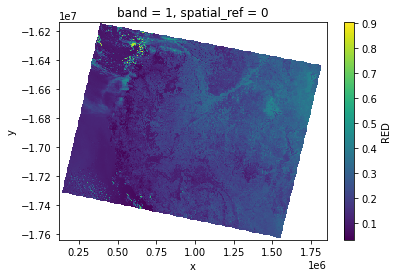

In [18]:
# You can use your own set by creating one.
# All the coefficients are set to 1.0 by default, so just modify the one you want
# The band keywords are {true_name}_{view_letter}
# RED is S2
user_set = SlstrRadAdjustTuple(S1_n=1.15, S2_o=1.12)

# However please bear in mind that if you want to reload the same band with a different adjustment, 
# you have to remove the temporary process folder or the previous band will be reloaded.
slstr_prod.clean_tmp()

# To apply these sets when loading a band, just add the keyword when loading it
red_pn_08 = slstr_bn_bands[RED]
slstr_red_bn = slstr_prod.load(
    RED,
    **{
        SLSTR_VIEW: SlstrView.NADIR,
        SLSTR_STRIPE: SlstrStripe.B,
        SLSTR_RAD_ADJUST: user_set
    }
)
red_user = slstr_red_bn[RED]
red_user[:, ::10, ::10].plot()

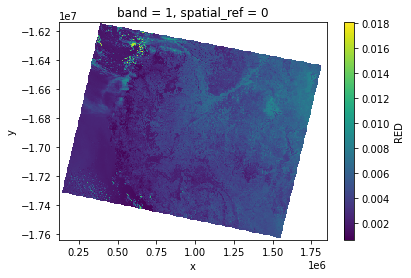

In [26]:
# We may need to collocate the bands if we want to work on two sets loaded apart
# Indeed, in EOReader, the bands are collocated when loaded together

# For example, if we wanted to work on the SWIR or F1 band, 
# as we first loaded them with the RED, they are collocated to this band (the first one) 
# Yet, their geodetic grid are different from the RED one (in and bn are slightly different than the an)
# So if we load on a second time only the SWIR or the F1 band, their are chances that the geocoding might be a little different
# The it is best to collocate the two bands just to be sure they will always match (and have the same size)

# To do so you could do:
from sertit import rasters

red_user = rasters.collocate(master_xds=red_pn_08, slave_xds=red_user)

# Here, it is useless as we work on the master band
abs(red_pn_08 - red_user)[:, ::10, ::10].plot()